In [1]:
import numpy as np
import json
import os
import glob
import sys
from pprint import pprint
from matplotlib import pyplot as plt

from domainbed.lib import misc, reporting
from domainbed import datasets
from domainbed import algorithms
from domainbed.lib.query import Q
from domainbed.model_selection import OracleSelectionMethod

# Arguments

In [2]:
base_output_dir="./checkpoints"
dataset_all = ['PACS', 'VLCS', 'OfficeHome', 'TerraIncognita', 'DomainNet']
algorithm_all = {'CLIPPretrained': 'CLIPPretrained',
                 'CLIPBase': 'SupCLIPBottleneckBase',
                 'CLIPCondCAD': 'SupCLIPBottleneckCondCAD'}

select_method = OracleSelectionMethod

# Helper Functions

In [3]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
             pretty(value, indent+1)
        else:
             print('\t' * (indent+1) + str(value))

def get_record(output_dir):
    print("Loading records from:", output_dir)
    records = reporting.load_records(output_dir)
    print("Total records:", len(records))

    return records

def get_results(out_dir, selection_method):
    """Given all records, print a results table for each dataset."""
    records = get_record(out_dir)
    
    grouped_records = reporting.get_grouped_records(records,
                                                    group_test_envs=True).map(
        lambda group:
        {**group, "sweep_acc": selection_method.sweep_acc(group["records"], return_extra=True)}
        ).filter(lambda g: g["sweep_acc"] is not None)

    # read algorithm names and sort (predefined order)
    alg_names = Q(records).select("args.algorithm").unique()
    assert len(alg_names) == 1
    algorithm = alg_names[0]

    # read dataset names and sort (lexicographic order)
    dataset_names = Q(records).select("args.dataset").unique().sorted()
    assert len(dataset_names) == 1
    dataset = dataset_names[0]

    trial_averages = (grouped_records
                      .filter_equals("algorithm, dataset", (algorithm, dataset))
                      .group("trial_seed")
                      .map(lambda trial_seed, group:
#                            group.select("sweep_acc").mean()
                           tuple(map(lambda y: sum(y) / float(len(y)), zip(*group.select("sweep_acc"))))
                           )
                      )
    
    tgt_all, src_all, tgt_in_all = zip(*trial_averages) 
    tgt_mean, src_mean, tgt_in_mean = 100 * np.mean(list(tgt_all)), 100 * np.mean(list(src_all)), 100 * np.mean(list(tgt_in_all))
    tgt_std, src_std, tgt_in_std = 100 * np.std(list(tgt_all)), 100 * np.std(list(src_all)), 100 * np.std(list(tgt_in_all))
    
    return (tgt_mean, src_mean, tgt_in_mean), (tgt_std, src_std, tgt_in_std)

# Collect Results

Collect the result dict for each setup:

In [4]:
def get_result(setup):
    result_dict = {}
    for dataset in dataset_all:
        result_dict[dataset] = {}
        sub_result_dict = result_dict[dataset]
        basedir = f'{base_output_dir}/{dataset}/{setup}'

        for alg_name, alg_name_long in algorithm_all.items():
            if alg_name in ['CLIPPretrained', 'CLIPBase']:
                sub_result_dict[alg_name] = {}
                subsub_result_dict = sub_result_dict[alg_name]

                output_dir = os.path.join(basedir, f'{alg_name_long}/base')
                print(output_dir)
                (acc_tgt, acc_src, acc_tgt_in), (acc_tgt_std, acc_src_std, acc_tgt_in_std) = get_results(output_dir, select_method)
                subsub_result_dict['acc_tgt'] = acc_tgt
                subsub_result_dict['acc_src'] = acc_src
                subsub_result_dict['acc_tgt_in'] = acc_tgt_in
                subsub_result_dict['acc_diff'] = acc_src - acc_tgt
                subsub_result_dict['acc_tgt_std'] = acc_tgt_std
                subsub_result_dict['acc_src_std'] = acc_src_std
                subsub_result_dict['acc_tgt_in_std'] = acc_tgt_in_std
            else:
                lambda_str_array = list(map(lambda s: s.split('_')[-1], glob.glob(os.path.join(basedir, f'{alg_name_long}/*'))))
                lambda_str_array = sorted(lambda_str_array, key=lambda r: float(r))
                lambda_val_array = np.array(list(map(lambda s: float(s), lambda_str_array)))

                for lambda_str in lambda_str_array:
                    sub_result_dict[alg_name + '_lambda_{}'.format(lambda_str)] = {}
                    subsub_result_dict = sub_result_dict[alg_name + '_lambda_{}'.format(lambda_str)]
                    output_dir = os.path.join(basedir, f'{alg_name_long}/lambda_{lambda_str}')

                    (acc_tgt, acc_src, acc_tgt_in), (acc_tgt_std, acc_src_std, acc_tgt_in_std) = get_results(output_dir, select_method)


                    subsub_result_dict['acc_tgt'] = acc_tgt
                    subsub_result_dict['acc_src'] = acc_src
                    subsub_result_dict['acc_tgt_in'] = acc_tgt_in
                    subsub_result_dict['acc_diff'] = acc_src - acc_tgt
                    subsub_result_dict['acc_tgt_std'] = acc_tgt_std
                    subsub_result_dict['acc_src_std'] = acc_src_std
                    subsub_result_dict['acc_tgt_in_std'] = acc_tgt_in_std
                    
    return result_dict


Result with CLIP-RN50 (CLIP S in our paper):

In [5]:
resnet_result_dict = get_result('clip_resnet')

./checkpoints/PACS/clip_resnet/CLIPPretrained/base
Loading records from: ./checkpoints/PACS/clip_resnet/CLIPPretrained/base


Total records: 20
./checkpoints/PACS/clip_resnet/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/PACS/clip_resnet/SupCLIPBottleneckBase/base


Total records: 2000
Loading records from: ./checkpoints/PACS/clip_resnet/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 2000
./checkpoints/VLCS/clip_resnet/CLIPPretrained/base
Loading records from: ./checkpoints/VLCS/clip_resnet/CLIPPretrained/base


Total records: 20
./checkpoints/VLCS/clip_resnet/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/VLCS/clip_resnet/SupCLIPBottleneckBase/base


Total records: 2000
Loading records from: ./checkpoints/VLCS/clip_resnet/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 2000
./checkpoints/OfficeHome/clip_resnet/CLIPPretrained/base
Loading records from: ./checkpoints/OfficeHome/clip_resnet/CLIPPretrained/base


Total records: 20
./checkpoints/OfficeHome/clip_resnet/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/OfficeHome/clip_resnet/SupCLIPBottleneckBase/base


Total records: 200
Loading records from: ./checkpoints/OfficeHome/clip_resnet/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 200
./checkpoints/TerraIncognita/clip_resnet/CLIPPretrained/base
Loading records from: ./checkpoints/TerraIncognita/clip_resnet/CLIPPretrained/base


Total records: 20
./checkpoints/TerraIncognita/clip_resnet/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/TerraIncognita/clip_resnet/SupCLIPBottleneckBase/base


Total records: 2169
Loading records from: ./checkpoints/TerraIncognita/clip_resnet/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 2122
./checkpoints/DomainNet/clip_resnet/CLIPPretrained/base
Loading records from: ./checkpoints/DomainNet/clip_resnet/CLIPPretrained/base


Total records: 30
./checkpoints/DomainNet/clip_resnet/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/DomainNet/clip_resnet/SupCLIPBottleneckBase/base


Total records: 300
Loading records from: ./checkpoints/DomainNet/clip_resnet/SupCLIPBottleneckCondCAD/lambda_1


Total records: 300


In [6]:
pretty(resnet_result_dict)

PACS
	CLIPPretrained
		acc_tgt
			90.28137968663346
		acc_src
			96.3824086169736
		acc_tgt_in
			90.28137968663346
		acc_diff
			6.101028930340149
		acc_tgt_std
			0.21754703716146506
		acc_src_std
			0.22848149248597874
		acc_tgt_in_std
			0.21754703716146506
	CLIPBase
		acc_tgt
			91.32533768704931
		acc_src
			96.40144610847135
		acc_tgt_in
			91.32533768704931
		acc_diff
			5.076108421422035
		acc_tgt_std
			0.3047843082109695
		acc_src_std
			0.21279016735772108
		acc_tgt_in_std
			0.3047843082109695
	CLIPCondCAD_lambda_1e-2
		acc_tgt
			92.0771514947144
		acc_src
			96.47309118379134
		acc_tgt_in
			92.0771514947144
		acc_diff
			4.39593968907694
		acc_tgt_std
			0.3244192850671674
		acc_src_std
			0.24639501394550897
		acc_tgt_in_std
			0.3244192850671674
VLCS
	CLIPPretrained
		acc_tgt
			81.08320767212291
		acc_src
			88.30551930040173
		acc_tgt_in
			81.08320767212291
		acc_diff
			7.222311628278817
		acc_tgt_std
			0.4956796202013862
		acc_src_std
			0.2927194264231173
		acc

Result with CLIP-ViT-B/32 (CLIP L in our paper):

In [7]:
vit_result_dict = get_result('clip_vit')

./checkpoints/PACS/clip_vit/CLIPPretrained/base
Loading records from: ./checkpoints/PACS/clip_vit/CLIPPretrained/base


Total records: 20
./checkpoints/PACS/clip_vit/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/PACS/clip_vit/SupCLIPBottleneckBase/base


Total records: 2000
Loading records from: ./checkpoints/PACS/clip_vit/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 2000
./checkpoints/VLCS/clip_vit/CLIPPretrained/base
Loading records from: ./checkpoints/VLCS/clip_vit/CLIPPretrained/base


Total records: 20
./checkpoints/VLCS/clip_vit/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/VLCS/clip_vit/SupCLIPBottleneckBase/base


Total records: 2000
Loading records from: ./checkpoints/VLCS/clip_vit/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 2000
./checkpoints/OfficeHome/clip_vit/CLIPPretrained/base
Loading records from: ./checkpoints/OfficeHome/clip_vit/CLIPPretrained/base


Total records: 20
./checkpoints/OfficeHome/clip_vit/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/OfficeHome/clip_vit/SupCLIPBottleneckBase/base


Total records: 200
Loading records from: ./checkpoints/OfficeHome/clip_vit/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 200
./checkpoints/TerraIncognita/clip_vit/CLIPPretrained/base
Loading records from: ./checkpoints/TerraIncognita/clip_vit/CLIPPretrained/base


Total records: 20
./checkpoints/TerraIncognita/clip_vit/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/TerraIncognita/clip_vit/SupCLIPBottleneckBase/base


Total records: 2015
Loading records from: ./checkpoints/TerraIncognita/clip_vit/SupCLIPBottleneckCondCAD/lambda_1e-2


Total records: 2008
./checkpoints/DomainNet/clip_vit/CLIPPretrained/base
Loading records from: ./checkpoints/DomainNet/clip_vit/CLIPPretrained/base


Total records: 30
./checkpoints/DomainNet/clip_vit/SupCLIPBottleneckBase/base
Loading records from: ./checkpoints/DomainNet/clip_vit/SupCLIPBottleneckBase/base


Total records: 300
Loading records from: ./checkpoints/DomainNet/clip_vit/SupCLIPBottleneckCondCAD/lambda_1e-1


Total records: 300


In [8]:
pretty(vit_result_dict)

PACS
	CLIPPretrained
		acc_tgt
			93.73387326180165
		acc_src
			97.6605702243746
		acc_tgt_in
			93.73387326180165
		acc_diff
			3.9266969625729473
		acc_tgt_std
			0.7873557873662019
		acc_src_std
			0.21480970079835698
		acc_tgt_in_std
			0.7873557873662019
	CLIPBase
		acc_tgt
			94.4970899368186
		acc_src
			97.7024309957262
		acc_tgt_in
			94.4970899368186
		acc_diff
			3.2053410589076066
		acc_tgt_std
			0.5086543006149403
		acc_src_std
			0.15615126934468956
		acc_tgt_in_std
			0.5086543006149403
	CLIPCondCAD_lambda_1e-2
		acc_tgt
			94.91006600764807
		acc_src
			97.67439343762041
		acc_tgt_in
			94.91006600764807
		acc_diff
			2.76432742997234
		acc_tgt_std
			0.3726537740856946
		acc_src_std
			0.21211662935990824
		acc_tgt_in_std
			0.3726537740856946
VLCS
	CLIPPretrained
		acc_tgt
			80.5326710462202
		acc_src
			88.47919536759268
		acc_tgt_in
			80.5326710462202
		acc_diff
			7.946524321372479
		acc_tgt_std
			0.3979490265240089
		acc_src_std
			0.5795521728529099
		acc_tg

# Plot Results

In [9]:
def plot_result(result_dict, plot_dataset, plot_y='acc_tgt', include=None, exclude=None, plot_std=False):
    plt.figure()
    sub_result_dict = result_dict[plot_dataset]
    plt_xs = []
    plt_ys = []
    plt_errs = []
    
    for k, v in sub_result_dict.items():
        subsub_result_dict = sub_result_dict[k]
        
        if include is not None and k not in include:
            continue
            
        if exclude is not None and k in exclude:
            continue
            
        plt_xs.append(k.replace('_', '\n'))
        plt_ys.append(subsub_result_dict[plot_y])
        plt_errs.append(subsub_result_dict[plot_y + '_std'])
    
    
    if not plot_std:
        plt.bar(plt_xs, plt_ys)
    else:
        plt.bar(plt_xs, plt_ys, yerr=plt_errs)
        
    for plt_x, plt_y, plt_err in zip(plt_xs, plt_ys, plt_errs):
        plt.text(plt_x, plt_y + .25, '{:.1f} +/- {:.1f}'.format(plt_y, plt_err) , color='blue', fontweight='bold')
            
    
    plt.xlabel('Method')
    plt.ylabel('Accuracy')
    plt.ylim([np.min(plt_ys)-0.5, np.max(plt_ys)+0.5])
        
    plt.show()

Visualize the results. Note that the results may be slightly different from the paper due to code cleaning. 

Finetuning without bottlenecks (CLIPBase) could be worse than CLIPPretrained due to overfitting to source domains, while finetuning with bottlenecks (CLIPCondCAD) leads to consistent improvement.

# DomainNet

CAD leads to significant improvments on DomainNet.

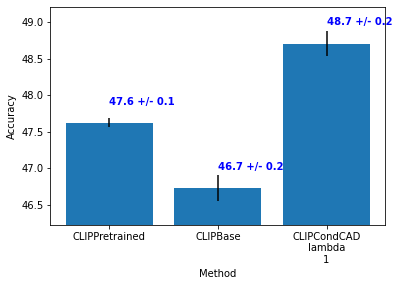

In [10]:
plot_result(resnet_result_dict, plot_dataset='DomainNet', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

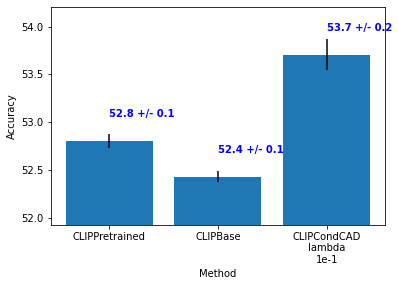

In [11]:
plot_result(vit_result_dict, plot_dataset='DomainNet', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## VLCS

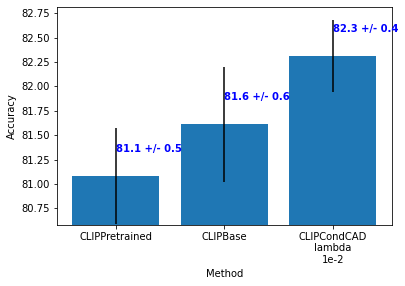

In [12]:
plot_result(resnet_result_dict, plot_dataset='VLCS', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

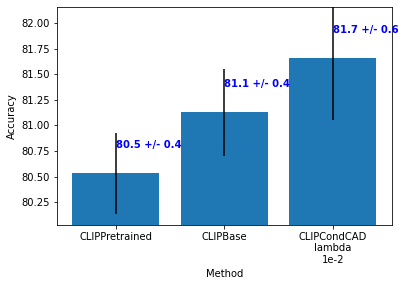

In [13]:
plot_result(vit_result_dict, plot_dataset='VLCS', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## PACS

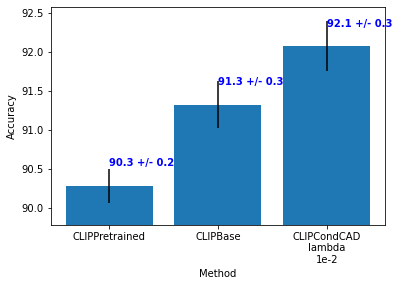

In [14]:
plot_result(resnet_result_dict, plot_dataset='PACS', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

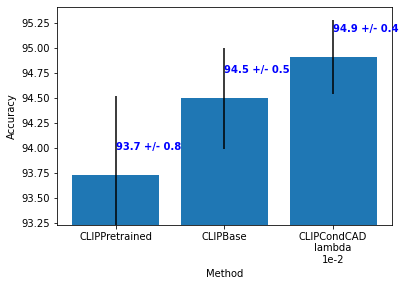

In [15]:
plot_result(vit_result_dict, plot_dataset='PACS', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## OfficeHome

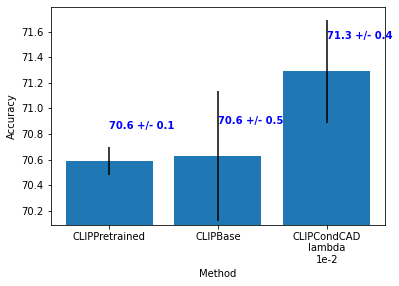

In [16]:
plot_result(resnet_result_dict, plot_dataset='OfficeHome', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

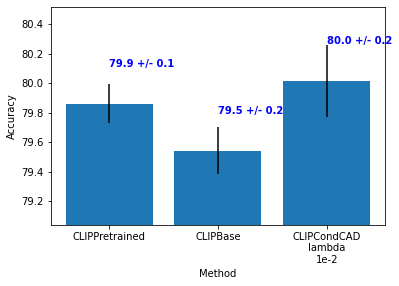

In [17]:
plot_result(vit_result_dict, plot_dataset='OfficeHome', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

## TerraIncognita

The poor performance on TerraIncognita is likely because CLIP's dataset does not cover such images (camera traps monitoring animals).

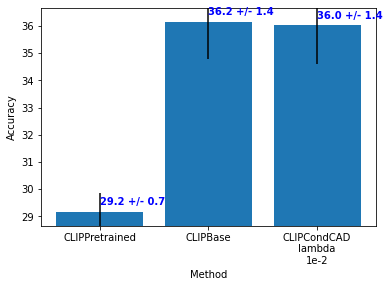

In [18]:
plot_result(resnet_result_dict, plot_dataset='TerraIncognita', plot_y='acc_tgt', 
            exclude=None, plot_std=True)

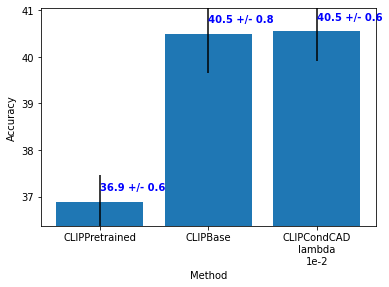

In [19]:
plot_result(vit_result_dict, plot_dataset='TerraIncognita', plot_y='acc_tgt', 
            exclude=None, plot_std=True)